In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# 新闻分类：多分类问题

在这一节中，我们将建立一个网络，将路透社新闻分为46个不同的互斥主题。由于我们有许多类，这个问题是“多分类”的一个实例，而且由于每个数据点只应被分类为一个类别，所以这个问题更具体地说是一个“单标签、多分类”的问题。如果每个数据点都属于多个类别，那么我们将面临一个“多标签、多分类”的问题。

# 路透社数据集
我们将使用路透社(Reuters)1986年发布的一组短讯及其主题--路透社数据集(ReutersDataSet)。这是一个非常简单，广泛使用的分类数据集，用于文本分类。它包括46个不同的主题；有些主题比其他主题更有代表性，但每个主题在训练集中至少有10个例子。

与IMDB和MNIST一样，路透社数据集被打包为Keras的一部分。

In [2]:
import tensorflow as tf

# 3-12 加载数据集
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 2s 1us/step


# 
与IMDB数据集一样，参数num_words=10000将数据限制为数据中最常见的10,000个单词。

我们有8,982个训练实例和2,246个测试实例

In [3]:
len(train_data)

8982

In [4]:
len(test_data)

2246

In [5]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

# 
以下是您如何将其解码回文字，以防您感到好奇：

In [6]:
word_index = reuters.get_word_index()

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

557056/550378 [==============================] - 1s 2us/step


In [7]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

# 
与示例关联的标签是介于0到45之间的整数：主题索引。

In [8]:
train_labels[10]

3

# 准备数据
我们可以使用与前面示例中完全相同的代码对数据进行矢量化：

In [9]:
# 3-14 编码数据
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# 数据向量化
x_train = vectorize_sequences(train_data)

x_test = vectorize_sequences(test_data)

# 
要将标签向量化，有两种方法：我们可以将标签列表转换为整数张量，或者使用 one-hot编码。热编码是一种广泛使用的分类数据格式，也称为“分类编码”。

In [10]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results


one_hot_train_labels = to_one_hot(train_labels)

one_hot_test_labels = to_one_hot(test_labels)

In [19]:
# 使用tf内置方法也可以实现这个操作
one_hot_train_labels = tf.one_hot(train_labels,depth=46)
one_hot_test_labels = tf.one_hot(test_labels,depth=46)

# 构建网络
这个分类问题看起来与我们以前的电影评论分类问题非常相似：在这两种情况下，我们都试图对简短的文本片段进行分类。然而，这里有一个新的限制：输出类的数量从2增加到46，即输出空间的维数要大得多。

在一堆Dense就像我们所使用的那样，每一层只能访问上一层输出中的信息。如果某一层删除了一些与分类问题相关的信息，则该信息永远无法被后续层恢复：每一层都有可能成为“信息瓶颈”。在前面的例子中，我们使用的是16维中间层，但是16维空间可能太有限，无法分离46个不同的类：这样的小层可能充当信息瓶颈，永久丢弃相关信息。

因此，我们将使用更大的层。让我们用64个单元：

In [20]:
# 3-15模型定义
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

In [21]:
# 3-16编译模型
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 
我们在训练数据中留出1000个样本作为验证集


In [22]:
# 3-17留出验证集
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [23]:
# 3-18训练模型
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 3s 390us/sample - loss: 2.6722 - accuracy: 0.5471 - val_loss: 1.7763 - val_accuracy: 0.6420
Epoch 2/20
7982/7982 [==============================] - 1s 130us/sample - loss: 1.4353 - accuracy: 0.7046 - val_loss: 1.3436 - val_accuracy: 0.7100
Epoch 3/20
7982/7982 [==============================] - 1s 170us/sample - loss: 1.0657 - accuracy: 0.7754 - val_loss: 1.1744 - val_accuracy: 0.7450
Epoch 4/20
7982/7982 [==============================] - 3s 381us/sample - loss: 0.8511 - accuracy: 0.8185 - val_loss: 1.0726 - val_accuracy: 0.7650
Epoch 5/20
7982/7982 [==============================] - 1s 123us/sample - loss: 0.6794 - accuracy: 0.8530 - val_loss: 1.0241 - val_accuracy: 0.7820
Epoch 6/20
7982/7982 [==============================] - 1s 127us/sample - loss: 0.5510 - accuracy: 0.8822 - val_loss: 0.9563 - val_accuracy: 0.7930
Epoch 7/20
7982/7982 [==============================] - 1s 117us

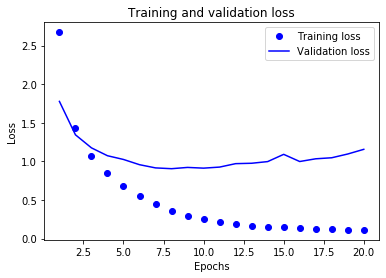

In [28]:
# 3-19绘制训练损失和验证损失
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

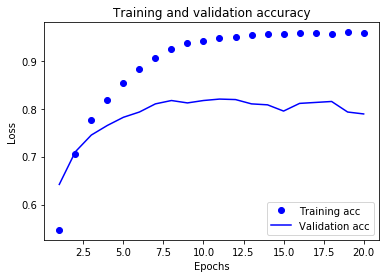

In [27]:
# 3-20绘制训练精度和验证精度
plt.clf()   

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 
网络在训练了9次后开始过拟合，我们从头开始训练一个新网络，共9个轮次。


In [29]:
# 3-21从头开始重新训练一个模型
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/8
7982/7982 [==============================] - 1s 156us/sample - loss: 2.4822 - accuracy: 0.5113 - val_loss: 1.6754 - val_accuracy: 0.6330
Epoch 2/8
7982/7982 [==============================] - 1s 114us/sample - loss: 1.3918 - accuracy: 0.6969 - val_loss: 1.2992 - val_accuracy: 0.7120
Epoch 3/8
7982/7982 [==============================] - 1s 120us/sample - loss: 1.0468 - accuracy: 0.7745 - val_loss: 1.1453 - val_accuracy: 0.7530
Epoch 4/8
7982/7982 [==============================] - 1s 107us/sample - loss: 0.8286 - accuracy: 0.8222 - val_loss: 1.0348 - val_accuracy: 0.7860
Epoch 5/8
7982/7982 [==============================] - 1s 107us/sample - loss: 0.6568 - accuracy: 0.8618 - val_loss: 0.9566 - val_accuracy: 0.8050
Epoch 6/8
7982/7982 [==============================] - 1s 119us/sample - loss: 0.5273 - accuracy: 0.8915 - val_loss: 0.9215 - val_accuracy: 0.8120
Epoch 7/8
7982/7982 [==============================] - 1s 107us/sample

In [30]:
results

[0.9626190709091146, 0.7871772]

# 在新数据上生成预测结果


In [32]:
# 3-22在新数据上生成预测结果
predictions = model.predict(x_test)

In [33]:
# 每个predictions是长度为46的向量：
predictions[0].shape

(46,)

In [34]:
# 这个向量中的元素之和为1：
np.sum(predictions[0])

1.0

In [35]:
# 最大的元素是预测类，即概率最大的类别：
np.argmax(predictions[0])

3

# 处理标签和损失的另一种方法
我们在前面提到过，另一种编码标签的方法是将它们转换为整数张量，如下所示：

In [36]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

# 
唯一会改变的是损失函数的选择。我们以前的损失，categorical_crossentropy，期望标签遵循分类编码。对于整数标签，我们应该使用sparse_categorical_crossentropy:

In [37]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

# 中间层维度足够大的重要性
我们在前面提到，由于我们的最终输出是46个维度，我们应该避免中间层的隐藏单位远远少于46个。现在，让我们看看当我们引入信息瓶颈时，中间层明显小于46维，例如4维，会发生什么。

In [38]:
# 3-23具有信息瓶颈的模型
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 229us/sample - loss: 2.5560 - accuracy: 0.5495 - val_loss: 1.7735 - val_accuracy: 0.6130
Epoch 2/20
7982/7982 [==============================] - 1s 187us/sample - loss: 1.5033 - accuracy: 0.6470 - val_loss: 1.4326 - val_accuracy: 0.6530
Epoch 3/20
7982/7982 [==============================] - 1s 186us/sample - loss: 1.2274 - accuracy: 0.7046 - val_loss: 1.3210 - val_accuracy: 0.6680
Epoch 4/20
7982/7982 [==============================] - 1s 164us/sample - loss: 1.0768 - accuracy: 0.7268 - val_loss: 1.2903 - val_accuracy: 0.6740
Epoch 5/20
7982/7982 [==============================] - 1s 183us/sample - loss: 0.9698 - accuracy: 0.7457 - val_loss: 1.2635 - val_accuracy: 0.6990
Epoch 6/20
7982/7982 [==============================] - 1s 184us/sample - loss: 0.8822 - accuracy: 0.7669 - val_loss: 1.2831 - val_accuracy: 0.6960
Epoch 7/20
7982/7982 [==============================] - 1s 167us

# 结论

如果您试图在N个类之间对数据点进行分类，网络的最后一层应该是大小为N的Dense层


one-hot编码使用分类交叉熵（categorical_crossentropy）作为损失函数

整数编码使用sparse_categoriacl_crossentropy作为损失函数